<a href="https://colab.research.google.com/github/sritishakodur/Mandarin-translator/blob/main/CN_EN_Translation_using_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'simhei:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F690442%2F1209810%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241011%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241011T034719Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6a03a9ed562699d9fef25f6559edd0aff7d1b6f06fa717d3a9d2ea6f94111ce600bbc3423ad56fad2134f801c58d918b979575828f509bf97938676b7dc5e8c4ef1ff529678c28e94e5e8fce711416e3a9b292f5e5b13688731428bf08fae90a65a6f02bb6582495ff26e9937da17fe2c1321979ba9fbba81a76683e0cbf93a7c34149fd3af07c17460d80a0f6ad2f08951bc4e770012dac47e6915c5aed32c7dfda559da13bb2656281ec277b20fbe940a9a4be40fa671744bec561ed2feac154accc50c0c1152ea42b5a66f1d26a00add0d4c134d3fb19a6710cf6bc2561bfa2b257e3f807c4a851792badd188834b30c6a461c09809d303811ba469cd03de,translation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3022708%2F5198173%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241011%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241011T034719Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D07e08f79aa515b8836edd87186490479cb0e3feefe6453fcd727468a4772a2f8ecbac4fcefa39758a23ea6157d784843b1f82aaad10f96d7fb691d403a4f5c72914801f358dda755a6294ad3401183aa312f106bba5480c86d377a557381b56c14e8e58546fcb33c9ae36fd198d5c89a3137c3852bc7983583de246bafbc3dfaee472783260cb6df708574672dfaa67ce6ff5bead2a9a8209f7c8bbcb02395a0c0b7d62ca510b08dd65498c5ebc0d27740c93dea9aadb2b606cb605f86f64db5ec2a33d6f6c700e052aa6ea8ad58e5b4b19e66e0383a18b1927db56ed313f63e3d3d394f1987cf89e08ae3d94446226c55da9e563eea93bf63918ddf5d4a35ef'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5321411 bytes downloaded
Downloaded and uncompressed: simhei
[==================================================] 631460860 bytes downloaded
Downloaded and uncompressed: translation
Data source import complete.


In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/simhei/simhei.ttf
/kaggle/input/translation/translation2019zh/translation2019zh_train.json
/kaggle/input/translation/translation2019zh/translation2019zh_valid.json


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
    # Set TensorFlow to use GPU
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(len(logical_devices), "GPU(s) are available.")
else:
    print("GPU is NOT available")
    # If GPU is not available, use CPU
    tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'), 'CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available
1 GPU(s) are available.


# References
- https://www.tensorflow.org/text/tutorials/transformer
- https://www.youtube.com/watch?v=zxQyTK8quyY

# Dataset preparation
- convert json to dataframe
- filter datarow that chinese translation contains number and english char
- tokenize the english and chinese sentences
- convert it into tensor
- split into train set and test set

In [5]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00


In [6]:
# from datasets import load_dataset
# dataset = load_dataset("swaption2009/20k-en-zh-translation-pinyin-hsk")

from datasets import load_dataset
huggingface_dataset = load_dataset("swaption2009/20k-en-zh-translation-pinyin-hsk",data_dir="")
huggingface_dataset = huggingface_dataset["train"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

hsk_1_4.txt:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/111820 [00:00<?, ? examples/s]

In [7]:

num_of_rows = huggingface_dataset.num_rows//5
huggingface_raw_data = pd.DataFrame(columns=["english","chinese"])
huggingface_datalist = []
print(num_of_rows)
for i in range(num_of_rows):
    english = huggingface_dataset[(i*5)+0]["text"].strip("english: ")
    chinese = huggingface_dataset[(i*5)+2]["text"].strip("mandarin: ")
#     print(english)
#     print(chinese)
#     print("="*10)
    df_row = pd.DataFrame([[english,chinese]], columns=["english", "chinese"])
    huggingface_raw_data = pd.concat([huggingface_raw_data, df_row], ignore_index=True)
display(huggingface_raw_data)

22364


english  \
0                          She wears a shawl with a mink   
1      `Abracadabra,' said the conjuror as he pulled ...   
2                           20 jin goes to 10 kilograms.   
3                   A balcony is a platform with a wall.   
4           A belt of trees grew between the two fields.   
...                                                  ...   
22359  The capital of Wisconsin, in the south-central...   
22360  The capital of Wisconsin, in the south-central...   
22361  What parents don't understand is that fat prov...   
22362  Any solution [to Soviet economic malaise], how...   
22363  A security device(often part of a terminal) th...   

                                                 chinese  
0                                             她戴着带有貂皮的披肩  
1                                魔术师口中念念有词, 把兔子从礼帽中掏了出来.  
2                                             二十市斤折合十公斤。  
3                                              阳台是有墙的平台。  
4                                           两块田之间有一条树木带。  
...                                                  ...  
22359  麦迪逊美国威斯康星州首府，位于该州的中南部，密尔沃基的西边。它于1836年被选定作为该州的首...  
22360  麦迪逊美国威斯康星州首府，位于该州的中南部，密尔沃基的西边。它于1836年被选定作为该州的首...  
22361  父母们所了不解的是，脂肪提供非常宝贵的热量，并且每个细胞都需要脂肪和胆固醇才能生长，她说。"...  
22362  不过，任何解决[苏联经济失调]办的法都受到权力危机的影响，在改革与开放，经济与政治之间产生一...  
22363  一种安全设备（通常是终端的一部分），它可以读取插入槽中的标记卡上的信息（这些信息往往以磁条码...  

[22364 rows x 2 columns]

In [8]:
import json

def jsontodf(json_filepath):
    json_list=[]

    #read the data line by line
    with open(json_filepath, 'r') as file:
        for idx,line in enumerate(file):
            json_list.append(line.strip())

    #convert from json list to object
    json_objects = [json.loads(json_str) for json_str in json_list]

    #json object to dataframe
    df = pd.DataFrame(json_objects)
    return df

raw_data = jsontodf("/kaggle/input/translation/translation2019zh/translation2019zh_valid.json")
display(raw_data)


english  \
0      Slowly and not without struggle, America began...   
1      I didn't own a Thesaurus until four years ago ...   
2      portlet, you must write three short deployment...   
3      Dithering is a technique that blends your colo...   
4      This paper discusses the petrologic characteri...   
...                                                  ...   
39318  The bill will now have to be passed by the Upp...   
39319  The influences of thermal debinding temperatur...   
39320            The man and woman are short and heigh .   
39321  That same old-fashioned car that I had seen ea...   
39322     He had a cold and spoke with a slight snuffle.   

                                                 chinese  
0                                   美国缓慢地开始倾听，但并非没有艰难曲折。  
1      直到四年前我才有了一本词典。我使用的是用89美分在K市场里买来的一本韦氏小词典。我从来不使用...  
2      portlet 之后，您必须编写三个简短的部署描述符：web.xml、portlet.xml...  
3                  抖动是关于颜色混合的技术，使你的作品看起来更圆滑，或者只是创作有趣的材质。  
4                 本文以珲春早第三纪含煤盆地的地质构违背景为依据，分析了煤系地层的岩石学特征。  
...                                                  ...  
39318                             目前，这项法案还必须获得印度议会上院的通过。  
39319               研究了热脱脂温度、时间、不同脱脂方式以及粘结剂组成对脱脂坯碳含量的影响。  
39320                                    这个男人，和这个女人都和瘦长。  
39321                     我之前看见的那辆老式轿车还停在原来的地方，也就是警察局对面。  
39322                                     他感冒了， 说话有点齉鼻儿。  

[39323 rows x 2 columns]

In [9]:
import re
def contains_english_or_number(text):
    pattern = r"^(?=.*[a-zA-Z])|(?=.*\d).+$"
    return bool(re.match(pattern, text))

#create a new boolean row to indicate which datarow has english char/number
raw_data["contains_english_or_number"] = raw_data["chinese"].apply(contains_english_or_number)

#filter out rows where the condition is True
filtered_df = raw_data[~raw_data["contains_english_or_number"]]

#drop the boolean columns
filtered_df = filtered_df.drop(columns=["contains_english_or_number"])

display(filtered_df)

english  \
0      Slowly and not without struggle, America began...   
3      Dithering is a technique that blends your colo...   
4      This paper discusses the petrologic characteri...   
6      Ruben: So, to heal (with capital letters) you ...   
7      The second encounter relates to my grandfather...   
...                                                  ...   
39318  The bill will now have to be passed by the Upp...   
39319  The influences of thermal debinding temperatur...   
39320            The man and woman are short and heigh .   
39321  That same old-fashioned car that I had seen ea...   
39322     He had a cold and spoke with a slight snuffle.   

                                      chinese  
0                        美国缓慢地开始倾听，但并非没有艰难曲折。  
3       抖动是关于颜色混合的技术，使你的作品看起来更圆滑，或者只是创作有趣的材质。  
4      本文以珲春早第三纪含煤盆地的地质构违背景为依据，分析了煤系地层的岩石学特征。  
6                        所以，要“治疗“他人你必须没有任何偏好。  
7                           第二次事件跟我爷爷的宝贝匣子有关。  
...                                       ...  
39318                  目前，这项法案还必须获得印度议会上院的通过。  
39319    研究了热脱脂温度、时间、不同脱脂方式以及粘结剂组成对脱脂坯碳含量的影响。  
39320                         这个男人，和这个女人都和瘦长。  
39321          我之前看见的那辆老式轿车还停在原来的地方，也就是警察局对面。  
39322                          他感冒了， 说话有点齉鼻儿。  

[30190 rows x 2 columns]

In [10]:
#create a new boolean row to indicate which datarow has english char/number
huggingface_raw_data["contains_english_or_number"] = huggingface_raw_data["chinese"].apply(contains_english_or_number)

#filter out rows where the condition is True
huggingface_filtered_df = huggingface_raw_data[~huggingface_raw_data["contains_english_or_number"]]

#drop the boolean columns
huggingface_filtered_df = huggingface_filtered_df.drop(columns=["contains_english_or_number"])

display(huggingface_filtered_df)

english  \
0                          She wears a shawl with a mink   
1      `Abracadabra,' said the conjuror as he pulled ...   
2                           20 jin goes to 10 kilograms.   
3                   A balcony is a platform with a wall.   
4           A belt of trees grew between the two fields.   
...                                                  ...   
22354  A verbal composition designed to convey experi...   
22355  And no sooner had Joan, his handsome, shallow-...   
22358  It's no secret that the Soviets are not happy ...   
22361  What parents don't understand is that fat prov...   
22362  Any solution [to Soviet economic malaise], how...   

                                                 chinese  
0                                             她戴着带有貂皮的披肩  
1                                魔术师口中念念有词, 把兔子从礼帽中掏了出来.  
2                                             二十市斤折合十公斤。  
3                                              阳台是有墙的平台。  
4                                           两块田之间有一条树木带。  
...                                                  ...  
22354  诗以生动的和充满想象的方式来表达经验、思想或情感的口述文学作品，以运用其声音和暗示力而选用浓...  
22355  他的妻子琼是一个健壮、浅薄的女人，也是孩子们随和的母亲。当她一听说自己高贵的地位时，便立刻想...  
22358  尽人皆知，苏联对古巴这时的发展感到不快，这位［欧洲］外交官说。可是他又说，苏联允许国内及东欧...  
22361  父母们所了不解的是，脂肪提供非常宝贵的热量，并且每个细胞都需要脂肪和胆固醇才能生长，她说。"...  
22362  不过，任何解决[苏联经济失调]办的法都受到权力危机的影响，在改革与开放，经济与政治之间产生一...  

[21928 rows x 2 columns]

In [11]:
filtered_df = pd.concat([filtered_df,huggingface_filtered_df])
# filtered_df = huggingface_filtered_df
# filtered_df["english"] = filtered_df["english"].apply(lambda x: x.lower())
display(filtered_df)

english  \
0      Slowly and not without struggle, America began...   
3      Dithering is a technique that blends your colo...   
4      This paper discusses the petrologic characteri...   
6      Ruben: So, to heal (with capital letters) you ...   
7      The second encounter relates to my grandfather...   
...                                                  ...   
22354  A verbal composition designed to convey experi...   
22355  And no sooner had Joan, his handsome, shallow-...   
22358  It's no secret that the Soviets are not happy ...   
22361  What parents don't understand is that fat prov...   
22362  Any solution [to Soviet economic malaise], how...   

                                                 chinese  
0                                   美国缓慢地开始倾听，但并非没有艰难曲折。  
3                  抖动是关于颜色混合的技术，使你的作品看起来更圆滑，或者只是创作有趣的材质。  
4                 本文以珲春早第三纪含煤盆地的地质构违背景为依据，分析了煤系地层的岩石学特征。  
6                                   所以，要“治疗“他人你必须没有任何偏好。  
7                                      第二次事件跟我爷爷的宝贝匣子有关。  
...                                                  ...  
22354  诗以生动的和充满想象的方式来表达经验、思想或情感的口述文学作品，以运用其声音和暗示力而选用浓...  
22355  他的妻子琼是一个健壮、浅薄的女人，也是孩子们随和的母亲。当她一听说自己高贵的地位时，便立刻想...  
22358  尽人皆知，苏联对古巴这时的发展感到不快，这位［欧洲］外交官说。可是他又说，苏联允许国内及东欧...  
22361  父母们所了不解的是，脂肪提供非常宝贵的热量，并且每个细胞都需要脂肪和胆固醇才能生长，她说。"...  
22362  不过，任何解决[苏联经济失调]办的法都受到权力危机的影响，在改革与开放，经济与政治之间产生一...  

[52118 rows x 2 columns]

In [12]:
from transformers import BertTokenizer
# tokenizer_en = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer_en = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer_cn = BertTokenizer.from_pretrained("bert-base-chinese")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

## Train test split

In [13]:
# english_seqs = tokenizer_en.tokenize(filtered_df["english"])
# chinese_seqs = tokenizer_cn.tokenize(filtered_df["chinese"])

# english_seqs = filtered_df["english"]
# chinese_seqs = filtered_df["chinese"]


In [14]:
english_seqs = filtered_df["english"].apply(lambda x: tokenizer_en.encode(x, add_special_tokens=True, padding=False))
chinese_seqs = filtered_df["chinese"].apply(lambda x: tokenizer_cn.encode(x, add_special_tokens=True, padding=False))

In [15]:
import math
MAX_TOKENIZE_LENGTH = max(english_seqs.str.len().max(),chinese_seqs.str.len().max()) #longest string
MAX_TOKENIZE_LENGTH = pow(2, math.ceil(math.log(MAX_TOKENIZE_LENGTH)/math.log(2))) #closest upper to the power of 2
EMBEDDING_DEPTH = 256


print(MAX_TOKENIZE_LENGTH)
print(EMBEDDING_DEPTH)


128
256


In [16]:
#for english to chinese translation
cn_set_start = chinese_seqs.apply(lambda x:x[:-1]) #remove [end]
cn_set_end = chinese_seqs.apply(lambda x:x[1:]) #remove [start]

#for chinese to english translation
en_set_start = english_seqs.apply(lambda x:x[:-1]) #remove [end]
en_set_end = english_seqs.apply(lambda x:x[1:]) #remove [start]

def add_padding(token_list, max_length):
    if len(token_list) < max_length:
        padding_length = max_length - len(token_list)
        token_list = token_list + [0] * padding_length
    else:
        token_list = token_list[:max_length]  # Trim to MAX_LENGTH if longer
    return token_list

#add padding
chinese_seqs = chinese_seqs.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH))
english_seqs = english_seqs.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH))

cn_set_start = cn_set_start.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH-1))
cn_set_end = cn_set_end.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH-1))

en_set_start = en_set_start.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH-1))
en_set_end = en_set_end.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH-1))


In [17]:
print("=====chinese tokenized data=====")
print(chinese_seqs.iloc[0])
print(cn_set_start.iloc[0])
print(cn_set_end.iloc[0])

print("=====english tokenized data=====")
print(english_seqs.iloc[0])
print(en_set_start.iloc[0])
print(en_set_end.iloc[0])

=====chinese tokenized data=====
[101, 5401, 1744, 5353, 2714, 1765, 2458, 1993, 967, 1420, 8024, 852, 2400, 7478, 3766, 3300, 5680, 7410, 3289, 2835, 511, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 5401, 1744, 5353, 2714, 1765, 2458, 1993, 967, 1420, 8024, 852, 2400, 7478, 3766, 3300, 5680, 7410, 3289, 2835, 511, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[5401, 1744, 5353, 2714, 1765, 2458, 1993, 967, 1420, 8024, 852, 2400, 7478, 376

In [18]:

data_size = len(filtered_df)
train_size = int(0.95*data_size)
test_size = data_size - train_size
print("train_size:",train_size)
print("test_size:",test_size)

en_training_data = []
cn_training_start_data = []
cn_training_end_data = []

cn_training_data = []
en_training_start_data = []
en_training_end_data = []

cn_to_en_training_data = []

en_testing_data = []
cn_testing_start_data = []
cn_testing_end_data = []

cn_testing_data = []
en_testing_start_data = []
en_testing_end_data = []

batch_size = 64

for i in range(data_size):
    if (i < train_size):
        en_training_data.append(tf.convert_to_tensor(english_seqs.iloc[i]))
        cn_training_start_data.append(tf.convert_to_tensor(cn_set_start.iloc[i]))
        cn_training_end_data.append(tf.convert_to_tensor(cn_set_end.iloc[i]))

        cn_training_data.append(tf.convert_to_tensor(chinese_seqs.iloc[i]))
        en_training_start_data.append(tf.convert_to_tensor(en_set_start.iloc[i]))
        en_training_end_data.append(tf.convert_to_tensor(en_set_end.iloc[i]))

    else:
        en_testing_data.append(tf.convert_to_tensor(english_seqs.iloc[i]))
        cn_testing_start_data.append(tf.convert_to_tensor(cn_set_start.iloc[i]))
        cn_testing_end_data.append(tf.convert_to_tensor(cn_set_end.iloc[i]))

        cn_testing_data.append(tf.convert_to_tensor(chinese_seqs.iloc[i]))
        en_testing_start_data.append(tf.convert_to_tensor(en_set_start.iloc[i]))
        en_testing_end_data.append(tf.convert_to_tensor(en_set_end.iloc[i]))


en_to_cn_train_set = tf.data.Dataset.from_tensor_slices(((tf.convert_to_tensor(en_training_data), tf.convert_to_tensor(cn_training_start_data)),\
                                                         tf.convert_to_tensor(cn_training_end_data)))

cn_to_en_train_set = tf.data.Dataset.from_tensor_slices(((tf.convert_to_tensor(cn_training_data), tf.convert_to_tensor(en_training_start_data)),\
                                                         tf.convert_to_tensor(en_training_end_data)))

en_to_cn_train_set = en_to_cn_train_set.batch(batch_size)
cn_to_en_train_set = cn_to_en_train_set.batch(batch_size)

en_to_cn_test_set = tf.data.Dataset.from_tensor_slices(((tf.convert_to_tensor(en_testing_data), tf.convert_to_tensor(cn_testing_start_data)),\
                                                         tf.convert_to_tensor(cn_testing_end_data)))

cn_to_en_test_set = tf.data.Dataset.from_tensor_slices(((tf.convert_to_tensor(cn_testing_data), tf.convert_to_tensor(en_testing_start_data)),\
                                                         tf.convert_to_tensor(en_testing_end_data)))

en_to_cn_test_set = en_to_cn_test_set.shuffle(train_size,reshuffle_each_iteration=True)
en_to_cn_test_set = en_to_cn_test_set.batch(batch_size)
cn_to_en_test_set = cn_to_en_test_set.batch(batch_size)

print("EN to CN train set")
for (en,cn),cn_label in en_to_cn_train_set.take(1):
    print(en.shape)
    print(cn.shape)
    print(cn_label.shape)

print("CN to EN train set")
for (cn,en),en_label in cn_to_en_train_set.take(1):
    print(cn.shape)
    print(en.shape)
    print(en_label.shape)


train_size: 49512
test_size: 2606
EN to CN train set
(64, 128)
(64, 127)
(64, 127)
CN to EN train set
(64, 128)
(64, 127)
(64, 127)


# Transformer model preparation
- embedding and positional encoding layer
    - `tf.keras.layers.Embedding()`
- add and normalize layer
    - `tf.keras.layers.Add()`
    - `tf.keras.layers.LayerNormalization()`
- attention layers (base attention, cross attention, global self attention, casual self attention)
- feed forward network

## Embedding and Positional encoding layer

In [19]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

(128, 256)


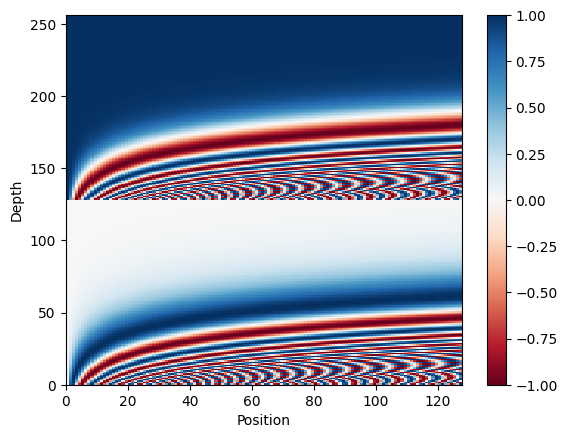

In [20]:
pos_encoding = positional_encoding(length=MAX_TOKENIZE_LENGTH, depth=EMBEDDING_DEPTH)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=MAX_TOKENIZE_LENGTH, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [22]:
embed_cn = PositionalEmbedding(vocab_size=tokenizer_cn.vocab_size, d_model=EMBEDDING_DEPTH)
embed_en = PositionalEmbedding(vocab_size=tokenizer_en.vocab_size, d_model=EMBEDDING_DEPTH)

cn_emb = embed_cn(cn)
en_emb = embed_en(en)

#CN to EN
print(cn_emb.shape) #embedding, positional encoding
print(en_emb.shape) #embedding, positional encoding

# # print(cn_emb._keras_mask)
# print(tf.reduce_sum(tf.cast(cn_emb._keras_mask[0], tf.int32)))
# print(tf.reduce_sum(tf.cast(cn_emb._keras_mask[1], tf.int32)))
# # print(en_emb._keras_mask)
# print(tf.reduce_sum(tf.cast(en_emb._keras_mask[0], tf.int32)))
# print(tf.reduce_sum(tf.cast(en_emb._keras_mask[1], tf.int32)))

(64, 128, 256)
(64, 127, 256)


## Base attention layer

In [23]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## Cross Attention Layer (Encoder-decoder attention)

In [24]:
class CrossAttention(BaseAttention):
    def call(self, x, context): #x = query, content = key,value pairs
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [25]:
sample_ca = CrossAttention(num_heads=2, key_dim=EMBEDDING_DEPTH)

# CN to EN
print(cn_emb.shape) #key,pair
print(en_emb.shape) #query
print(sample_ca(en_emb, cn_emb).shape)

(64, 128, 256)
(64, 127, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 127, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Global self attention layer (used in encoder)

In [26]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [27]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=EMBEDDING_DEPTH)

# CN to EN
print(cn_emb.shape)
print(sample_gsa(cn_emb).shape)

(64, 128, 256)
(64, 128, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Causal self attention layer (used in decoder)

In [28]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [29]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=EMBEDDING_DEPTH)

# CN to EN
print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 127, 256)
(64, 127, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## Feed forward layer (used in encoder and decoder)

In [30]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [31]:
sample_ffn = FeedForward(EMBEDDING_DEPTH,MAX_TOKENIZE_LENGTH)

#CN to EN
print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 127, 256)
(64, 127, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


# Transformer model formation
- Encoder
- Decoder

## Encoder

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [33]:
sample_encoder_layer = EncoderLayer(d_model=EMBEDDING_DEPTH, num_heads=8, dff=MAX_TOKENIZE_LENGTH)

#CN to EN
print(en_emb.shape)
print(sample_encoder_layer(en_emb).shape)

(64, 127, 256)
(64, 127, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_1' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_1' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(

In [34]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [35]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=EMBEDDING_DEPTH,
                         num_heads=8,
                         dff=MAX_TOKENIZE_LENGTH,
                         vocab_size=tokenizer_cn.vocab_size)

sample_encoder_output = sample_encoder(cn, training=False)

# Print the shape.
#CN to EN
print(cn.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_2' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_2' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(

(64, 128)
(64, 128, 256)


## Decoder

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [37]:
sample_decoder_layer = DecoderLayer(d_model=EMBEDDING_DEPTH, num_heads=8, dff=MAX_TOKENIZE_LENGTH)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=cn_emb)

#CN to EN
print(en_emb.shape)
print(cn_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention_1' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_6' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings

(64, 127, 256)
(64, 128, 256)
(64, 127, 256)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'feed_forward_6' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'decoder_layer' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [38]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [39]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=EMBEDDING_DEPTH,
                         num_heads=8,
                         dff=MAX_TOKENIZE_LENGTH,
                         vocab_size=tokenizer_en.vocab_size)

output = sample_decoder(
    x=en,
    context=cn_emb)

# Print the shapes.
#CN to EN
print(en.shape)
print(cn_emb.shape)
print(output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'sequential_7' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings

(64, 127)
(64, 128, 256)
(64, 127, 256)


In [40]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 127, 128])

# Transformer
- connect the `Encoder` and `Decoder` together
- will return a list with target output vocab size, whereby the predicted vocab will has the highest value among all

In [46]:
# For saving custom object
tf.keras.utils.get_custom_objects().clear()  # clear previous objects

@tf.keras.utils.register_keras_serializable()
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            del logits._keras_mask
        except AttributeError:
            pass

        return logits


In [47]:
num_layers = 1
d_model = EMBEDDING_DEPTH
dff = MAX_TOKENIZE_LENGTH
num_heads = 8
dropout_rate = 0.1

In [48]:
cn_to_en_transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer_cn.vocab_size,
    target_vocab_size=tokenizer_en.vocab_size,
    dropout_rate=dropout_rate)

In [49]:
output = cn_to_en_transformer((cn, en))

print(en.shape)
print(cn.shape)
print(output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

(64, 127)
(64, 128)
(64, 127, 28996)


In [50]:
attn_scores = cn_to_en_transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 127, 128)


In [51]:
cn_to_en_transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)                  │ ?                           │       7,579,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │      11,697,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (64, 127, 28996)            │       7,451,972 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,728,772 (101.96 MB)

 Trainable params: 26,728,772 (101.96 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [54]:
# Correct import for saving custom objects
@tf.keras.utils.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            'd_model': int(self.d_model),
            'warmup_steps': int(self.warmup_steps)
        }

# Instantiate the learning rate
learning_rate = CustomSchedule(d_model)

# Correct import for saving custom optimizer
@tf.keras.utils.register_keras_serializable()
class CustomAdam(tf.keras.optimizers.Adam):
    def __init__(self, custom_param, **kwargs):
        super(CustomAdam, self).__init__(**kwargs)
        self.custom_param = custom_param  # This is the learning rate (custom schedule)

    def get_config(self):
        config = super(CustomAdam, self).get_config()
        config.update({
            'custom_param': self.custom_param
        })
        return config

# Instantiate the optimizer
optimizer = CustomAdam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


Text(0.5, 0, 'Train Step')

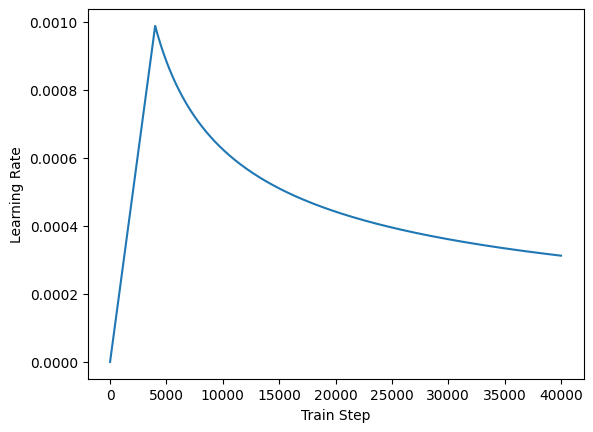

In [55]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [56]:
# Correct import for saving custom functions
@tf.keras.utils.register_keras_serializable()
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

@tf.keras.utils.register_keras_serializable()
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)


In [57]:
cn_to_en_transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [59]:
# history = cn_to_en_transformer.fit(cn_to_en_train_set, epochs=2, validation_data=cn_to_en_test_set)
history = cn_to_en_transformer.fit(cn_to_en_train_set, epochs=25, validation_data=cn_to_en_test_set)

Epoch 1/25
774/774 ━━━━━━━━━━━━━━━━━━━━ 210s 271ms/step - loss: 6.5598 - masked_accuracy: 0.1619 - val_loss: 5.0888 - val_masked_accuracy: 0.2606
Epoch 2/25
774/774 ━━━━━━━━━━━━━━━━━━━━ 186s 240ms/step - loss: 5.3439 - masked_accuracy: 0.2338 - val_loss: 4.7228 - val_masked_accuracy: 0.2905
Epoch 3/25
774/774 ━━━━━━━━━━━━━━━━━━━━ 204s 243ms/step - loss: 4.8000 - masked_accuracy: 0.2643 - val_loss: 4.5993 - val_masked_accuracy: 0.3050
Epoch 4/25
774/774 ━━━━━━━━━━━━━━━━━━━━ 191s 246ms/step - loss: 4.3791 - masked_accuracy: 0.2910 - val_loss: 4.5818 - val_masked_accuracy: 0.3137
Epoch 5/25
774/774 ━━━━━━━━━━━━━━━━━━━━ 200s 244ms/step - loss: 4.0354 - masked_accuracy: 0.3167 - val_loss: 4.6371 - val_masked_accuracy: 0.3184
Epoch 6/25
774/774 ━━━━━━━━━━━━━━━━━━━━ 191s 247ms/step - loss: 3.7537 - masked_accuracy: 0.3412 - val_loss: 4.6656 - val_masked_accuracy: 0.3273
Epoch 7/25
774/774 ━━━━━━━━━━━━━━━━━━━━ 191s 247ms/step - loss: 3.5106 - masked_accuracy: 0.3667 - val_loss: 4.7792 - val_ma

loss  masked_accuracy  val_loss  val_masked_accuracy  epoch
20  1.666593         0.635470  5.989071             0.324079     20
21  1.634598         0.640548  6.099271             0.320449     21
22  1.608932         0.644344  6.100451             0.319618     22
23  1.580631         0.648632  6.118207             0.325885     23
24  1.557797         0.652772  6.132761             0.324539     24

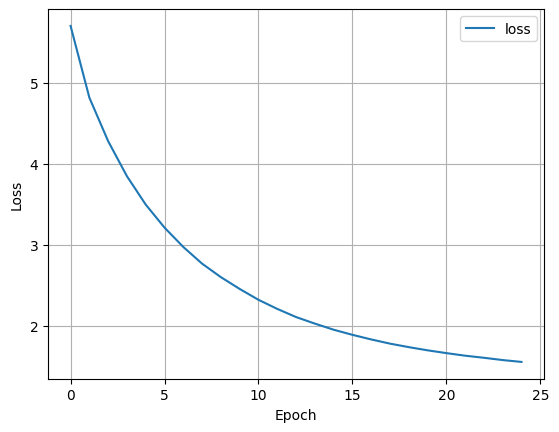

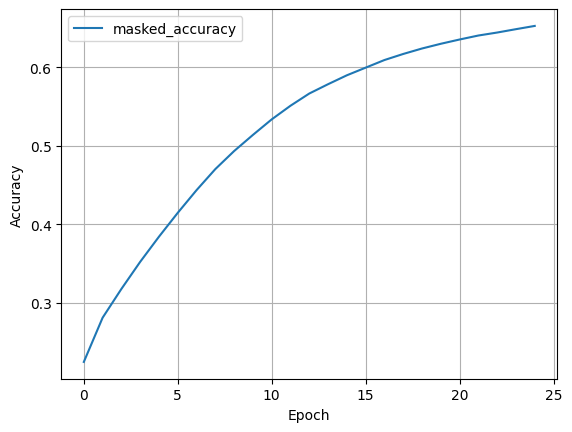

In [60]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.tail())

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
def plot_accuracy(history):
    plt.plot(history.history['masked_accuracy'], label='masked_accuracy')
    #plt.plot(history.history['val_masked_accuracy'], label='val_masked_accuracy')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.figure()
plot_loss(history)
plt.figure()
plot_accuracy(history)

# Model Testing
- using the dataset data to do testing
- using custom sentence to do testing

In [61]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [62]:
class Translator(tf.Module):
    def __init__(self, input_tonkenizer,output_tokenizer, transformer):
        self.input_tonkenizer = input_tonkenizer
        self.output_tokenizer = output_tokenizer
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENIZE_LENGTH):
        # For input sentence , hence adding the `[START]` and `[END]` tokens.
        sentence = tf.constant(self.input_tonkenizer.encode(sentence, add_special_tokens=True))[tf.newaxis]
        encoder_input = sentence

        # For output sentence, initialize the output with the `[START]` token.
        start_end = self.output_tokenizer.encode("", add_special_tokens=True)
#         print(start_end)
        start = tf.constant(start_end[0],dtype=tf.int64)[tf.newaxis]
        end = tf.constant(start_end[1],dtype=tf.int64)[tf.newaxis]
#         print(start,end)

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

#         print(encoder_input.shape)
#         print(output_array.shape)


        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
#             print(output)
            predictions = self.transformer([encoder_input, output], training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
#         print(output.shape)
#         print(output)
        text = self.output_tokenizer.decode(output[0], skip_special_tokens=True)  # Shape: `()`.

#         tokens = self.output_tokenizer.convert_ids_to_tokens(output)[0]

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, attention_weights
#         return text, tokens, attention_weights

translator = Translator(tokenizer_cn,tokenizer_en, cn_to_en_transformer)

In [63]:
sentence = "你好，欢迎来到中国"
ground_truth = 'Hello, Welcome to China'

# encoded_text = tf.constant(tokenizer_cn.encode("你好", add_special_tokens=True))
# print(encoded_text)
# print(tokenizer_cn.decode(encoded_text))

translated_text, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

Input:         : 你好，欢迎来到中国
Prediction     : You are welcome to welcome to China.
Ground truth   : Hello, Welcome to China


In [64]:
sentence = "早上好，很高心见到你"
ground_truth = 'Good Morning, nice to meet you'

translated_text, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : 早上好，很高心见到你
Prediction     : You are very noble early to look after you.
Ground truth   : Good Morning, nice to meet you


In [65]:
sentence = "祝您有个美好的一天"
ground_truth = 'Have a nice day'

translated_text, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : 祝您有个美好的一天
Prediction     : A happy woman who has a man in which a is a day.
Ground truth   : Have a nice day


In [70]:
pip install nltk

In [71]:
import nltk
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download NLTK data for BLEU if not already available
nltk.download('punkt')

# Function to calculate BLEU score for a dataset
def calculate_bleu_scores(huggingface_raw_data):
    # Initialize list to hold BLEU scores
    scores_list = []

    # Define a smoothing function for BLEU
    smoothing = SmoothingFunction().method1

    # Iterate over rows in the DataFrame
    for index, row in huggingface_raw_data.iterrows():
        chinese_text = row['chinese']
        english_translation = row['english']

        # Tokenize both Chinese and English text
        reference = [nltk.word_tokenize(chinese_text)]  # Reference needs to be a list of tokenized reference sentences
        candidate = nltk.word_tokenize(english_translation)  # Candidate is the translated sentence

        # Calculate BLEU score (you can adjust the weights for different n-gram precisions)
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing)

        # Collect BLEU score for this sentence pair
        scores_list.append(bleu_score)

    # Create a DataFrame to store the BLEU scores
    scores_df = pd.DataFrame(scores_list, columns=['BLEU_score'])

    # Calculate summary statistics: max, min, and average
    summary_stats = {
        'max': scores_df['BLEU_score'].max(),
        'min': scores_df['BLEU_score'].min(),
        'average': scores_df['BLEU_score'].mean()
    }

    return scores_df, summary_stats

# Example usage (ensure huggingface_raw_data contains 'english' and 'chinese' columns)
bleu_results, bleu_summary_stats = calculate_bleu_scores(huggingface_raw_data)

# Display the detailed results
print("BLEU Detailed Results:")
print(bleu_results)

# Display summary stats (max, min, average)
print("\nSummary Stats (Max, Min, Average):")
print(f"Max BLEU score: {bleu_summary_stats['max']}")
print(f"Min BLEU score: {bleu_summary_stats['min']}")
print(f"Average BLEU score: {bleu_summary_stats['average']}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


BLEU Detailed Results:
       BLEU_score
0        0.000000
1        0.013218
2        0.000000
3        0.000000
4        0.000000
...           ...
22359    0.000000
22360    0.000000
22361    0.003325
22362    0.004189
22363    0.000000

[22364 rows x 1 columns]

Summary Stats (Max, Min, Average):
Max BLEU score: 0.09058752341587764
Min BLEU score: 0.0
Average BLEU score: 0.006179644132180137


In [72]:
pip install bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00


In [73]:
from bert_score import score

# Example sentences
chinese_text = ["这是一个例子"]
english_translation = ["This is an example"]

P, R, F1 = score(english_translation, chinese_text, lang="en")
print(f"BERTScore F1: {F1.mean()}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore F1: 0.7401105165481567


In [74]:
pip install transformers torch scikit-learn


In [76]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load the multilingual BERT model and tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to compute sentence embeddings in batches
def get_sentence_embeddings(sentences):
    # Prepare inputs for the model
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True).to(device)

    # Disable gradient calculations for efficiency
    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate mean of the last hidden states
    return torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()  # Move to CPU for further processing

# Function to calculate cosine similarity for the dataset
def calculate_cosine_similarity(huggingface_raw_data):
    similarity_list = []

    # Extract sentences from the DataFrame
    chinese_sentences = huggingface_raw_data['chinese'].tolist()
    english_sentences = huggingface_raw_data['english'].tolist()

    # Get embeddings for both Chinese and English sentences in batches
    chinese_embeddings = get_sentence_embeddings(chinese_sentences)
    english_embeddings = get_sentence_embeddings(english_sentences)

    # Calculate cosine similarities for all pairs
    similarity_list = cosine_similarity(chinese_embeddings, english_embeddings).diagonal()

    # Create a DataFrame to store the Cosine Similarity scores
    similarity_df = pd.DataFrame(similarity_list, columns=['Cosine_Similarity'])

    # Calculate summary statistics: max, min, and average
    summary_stats = {
        'max': similarity_df['Cosine_Similarity'].max(),
        'min': similarity_df['Cosine_Similarity'].min(),
        'average': similarity_df['Cosine_Similarity'].mean()
    }

    return similarity_df, summary_stats

# Example usage (ensure huggingface_raw_data contains 'english' and 'chinese' columns)
# Assuming you have a DataFrame named huggingface_raw_data with 'chinese' and 'english' columns
# You can replace this with your actual data loading code
# huggingface_raw_data = pd.read_csv('path_to_your_data.csv')  # Load your data here

# Uncomment the line below when you have your dataset ready
# cosine_results, cosine_summary_stats = calculate_cosine_similarity(huggingface_raw_data)

# Display or save the results
# print("Cosine Similarity Detailed Results:")
# print(cosine_results)

# print("\nSummary Stats (Max, Min, Average):")
# print(f"Max Cosine Similarity: {cosine_summary_stats['max']}")
# print(f"Min Cosine Similarity: {cosine_summary_stats['min']}")
# print(f"Average Cosine Similarity: {cosine_summary_stats['average']}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [77]:
print(huggingface_raw_data.head())


                                             english                  chinese  \
0                      She wears a shawl with a mink               她戴着带有貂皮的披肩   
1  `Abracadabra,' said the conjuror as he pulled ...  魔术师口中念念有词, 把兔子从礼帽中掏了出来.   
2                       20 jin goes to 10 kilograms.               二十市斤折合十公斤。   
3               A balcony is a platform with a wall.                阳台是有墙的平台。   
4       A belt of trees grew between the two fields.             两块田之间有一条树木带。   

   contains_english_or_number  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False  


In [78]:
sample_chinese = ["你好", "这是一个测试"]
sample_english = ["Hello", "This is a test"]

chinese_embeddings = get_sentence_embeddings(sample_chinese)
english_embeddings = get_sentence_embeddings(sample_english)

print("Chinese Embeddings:", chinese_embeddings)
print("English Embeddings:", english_embeddings)


Chinese Embeddings: [[ 0.36313105 -0.5013344   0.40969986 ...  1.3534216  -0.26544264
   0.8107257 ]
 [-0.16172692 -0.2991106   0.48887393 ... -0.38418108  0.1836846
   0.50324243]]
English Embeddings: [[ 0.6601503  -0.52314985  0.6231183  ...  0.14161377 -0.18764204
  -0.12801884]
 [ 0.01232992  0.01517136  0.26583073 ...  0.6060171  -0.04442195
   0.46732688]]


In [79]:
similarity = cosine_similarity(chinese_embeddings, english_embeddings).diagonal()
print("Cosine Similarity Values:", similarity)


Cosine Similarity Values: [0.5094271  0.66454285]


In [80]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [82]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load the multilingual BERT model and tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to compute sentence embeddings in batches
def get_sentence_embeddings(sentences):
    inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()

# Function to calculate cosine similarity for the dataset
def calculate_cosine_similarity(huggingface_raw_data):
    similarity_list = []

    # Check input data
    print(huggingface_raw_data.head())  # Verify input data

    chinese_sentences = huggingface_raw_data['chinese'].tolist()
    english_sentences = huggingface_raw_data['english'].tolist()

    # Get embeddings for both Chinese and English sentences in batches
    chinese_embeddings = get_sentence_embeddings(chinese_sentences)
    english_embeddings = get_sentence_embeddings(english_sentences)

    # Calculate cosine similarities for all pairs
    similarity_list = cosine_similarity(chinese_embeddings, english_embeddings).diagonal()

    # Create a DataFrame to store the Cosine Similarity scores
    similarity_df = pd.DataFrame(similarity_list, columns=['Cosine_Similarity'])

    # Calculate summary statistics: max, min, and average
    summary_stats = {
        'max': similarity_df['Cosine_Similarity'].max(),
        'min': similarity_df['Cosine_Similarity'].min(),
        'average': similarity_df['Cosine_Similarity'].mean()
    }

    return similarity_df, summary_stats

# Example usage (ensure huggingface_raw_data contains 'english' and 'chinese' columns)
# Load your dataset here
# huggingface_raw_data = pd.read_csv('path_to_your_data.csv')  # Load your data here

# Uncomment the line below when you have your dataset ready
# cosine_results, cosine_summary_stats = calculate_cosine_similarity(huggingface_raw_data)

# Display or save the results
# print("Cosine Similarity Detailed Results:")
# print(cosine_results)

# print("\nSummary Stats (Max, Min, Average):")
# print(f"Max Cosine Similarity: {cosine_summary_stats['max']}")
# print(f"Min Cosine Similarity: {cosine_summary_stats['min']}")
# print(f"Average Cosine Similarity: {cosine_summary_stats['average']}")


# Attention plot

In [83]:
def plot_attention_head(in_tokens, in_tokenizer, in_font, translated_tokens, translated_tokenizer, attention):
    # The model didn't generate `<START>` in the output. Skip it.
#     translated_tokens = translated_tokens[1:]
    in_tokens = in_tokens[0]
    translated_tokens = translated_tokens[0]

    in_tokens = in_tokenizer.decode(in_tokens).split(" ")
    #print(in_tokens)

    translated_tokens = translated_tokenizer.decode(translated_tokens,skip_special_tokens=True).split(" ")
    #print(translated_tokens)

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label for label in in_tokens]
    ax.set_xticklabels(
      labels, rotation=90, fontproperties=in_font)

    labels = [label for label in translated_tokens]
    ax.set_yticklabels(labels)

In [84]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
print(attention_weights.shape)
print(attention.shape)
# print(attention)

(1, 8, 15, 11)
(15, 11)


In [85]:
in_tokens = tf.constant(tokenizer_cn.encode(sentence, add_special_tokens=True))[tf.newaxis]
print(in_tokens.shape)

(1, 11)


In [86]:
out_tokens = tf.constant(tokenizer_en.encode(translated_text, add_special_tokens=False))[tf.newaxis]
print(out_tokens.shape)

(1, 14)


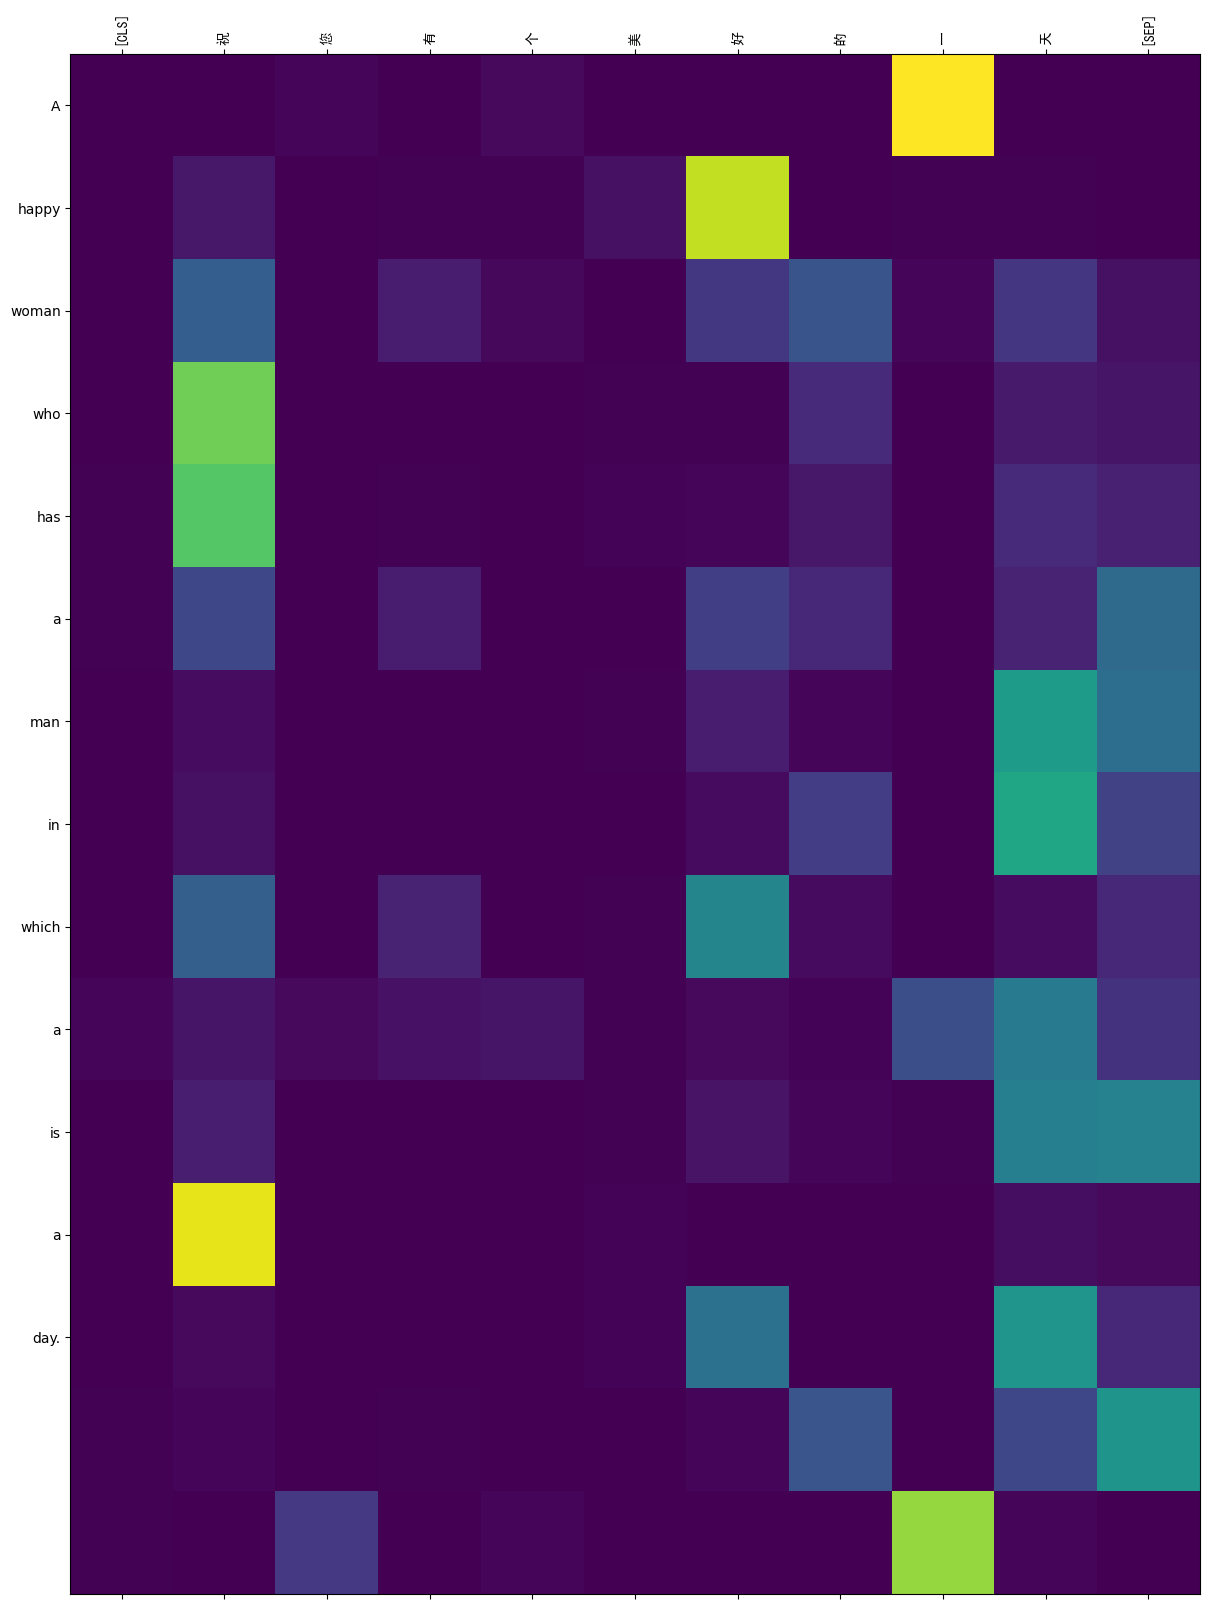

In [87]:

from matplotlib.font_manager import FontProperties

# Specify the path to the downloaded SimHei.ttf font file
simhei_path = '/kaggle/input/simhei/simhei.ttf'

# Create a font property with SimHei font
simhei_font = FontProperties(fname=simhei_path)

plot_size = 20
plt.figure(figsize=(plot_size,plot_size))
plot_attention_head(in_tokens, tokenizer_cn, simhei_font, out_tokens, tokenizer_en, attention)

In [88]:
def plot_attention_weights(in_tokens, tokenizer_cn, out_tokens, tokenizer_en, attention_heads):

    plot_size = 20
    fig = plt.figure(figsize=(plot_size,plot_size))#plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(in_tokens, tokenizer_cn, simhei_font, out_tokens, tokenizer_en, head)

        ax.set_xlabel(f'Head {h+1}')

#     plt.tight_layout()
    plt.show()

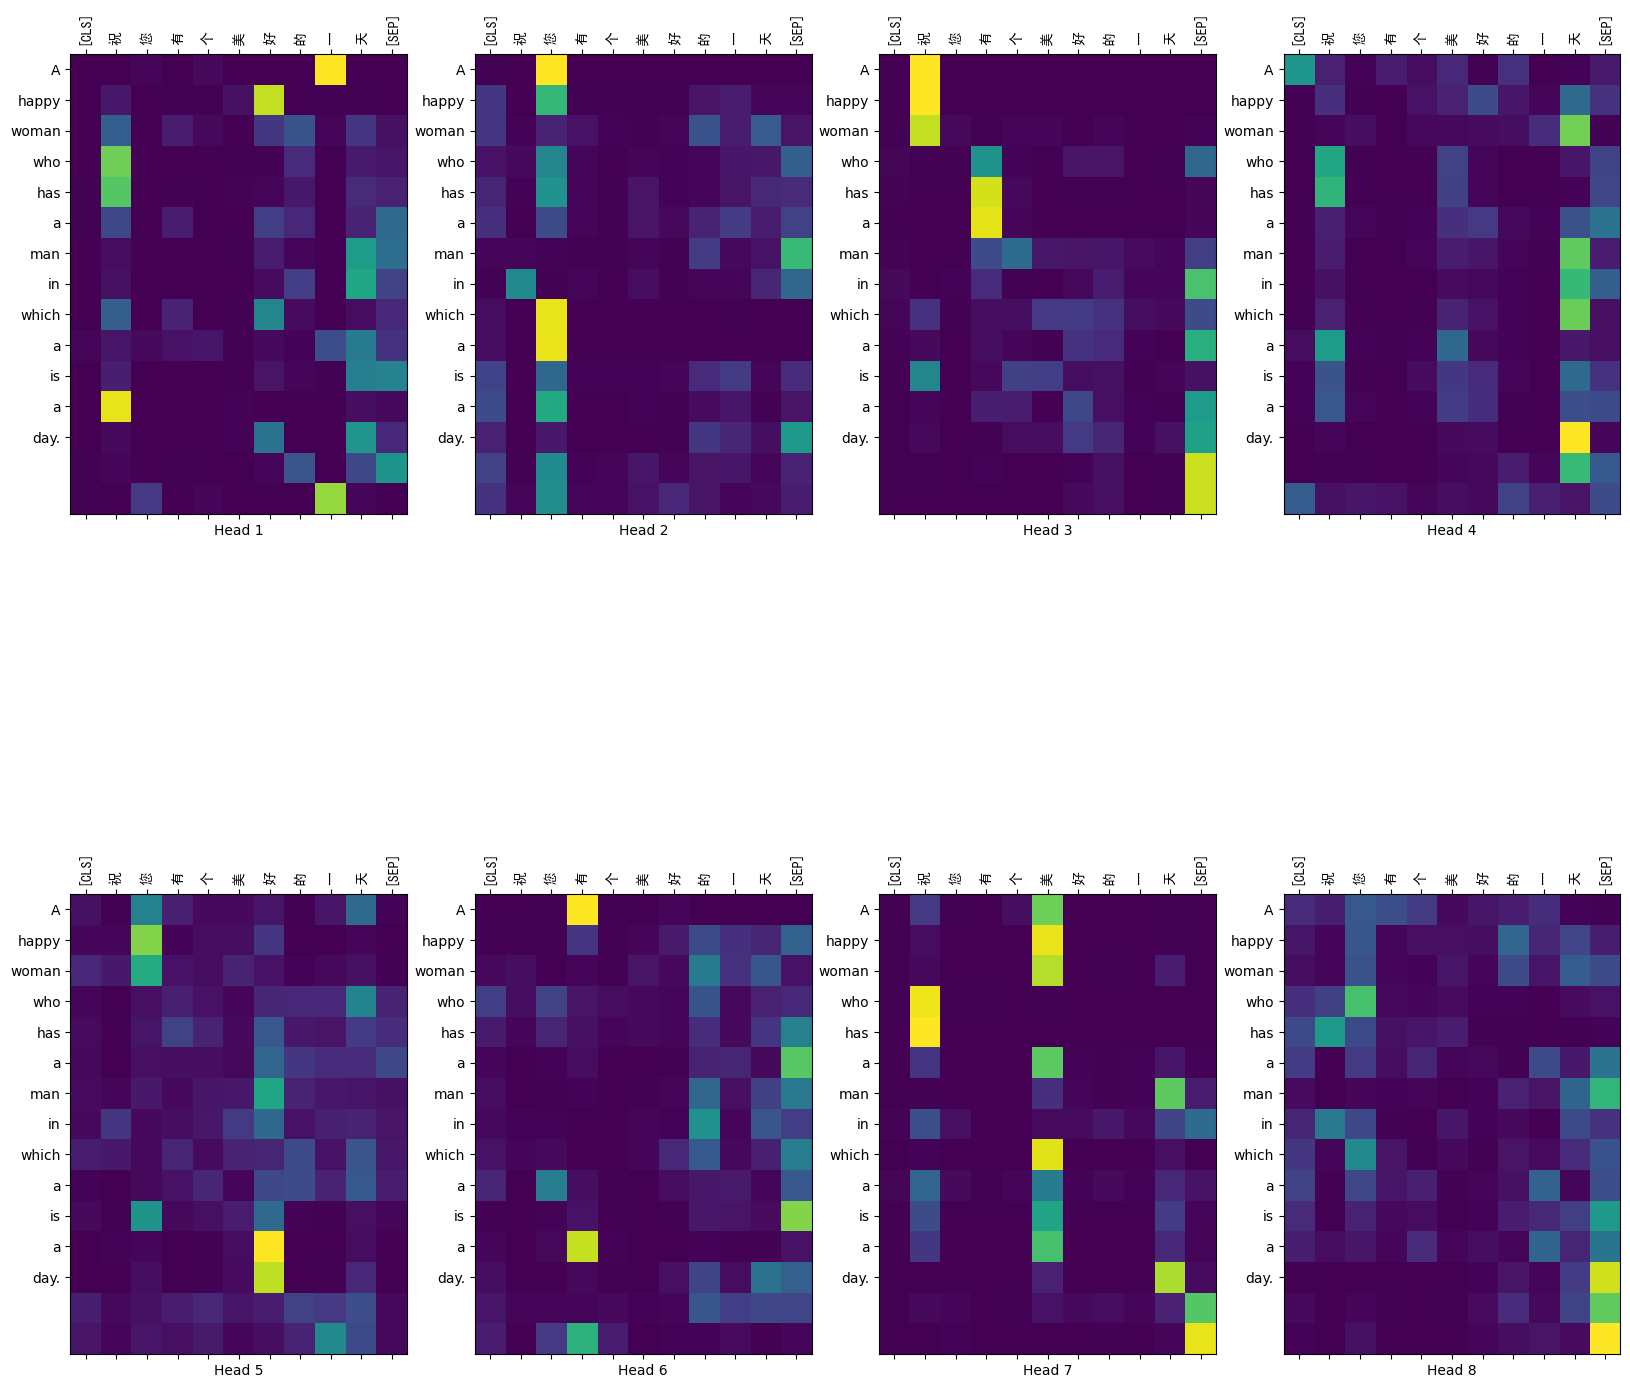

In [89]:
plot_attention_weights(in_tokens, tokenizer_cn, out_tokens, tokenizer_en, attention_weights[0])

# Model Export
- export the `transformer` in the `translator` only, as the tokenizer used is using huggingface bert tokenizer
- make sure the saved transformer has the same result as the trained transformer

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
